# FRMOD tutorial

This notebook is a guide for performing a frequency (or likelihood) ratio style landslide susceptibility analysis with the frmod Python package.

## The analysis in brief
The script uses a probabilistic method for landslide susceptibility assessment. It assumes, that landslide-affected areas in the future will have similar terrain and environmental conditions to the already landslide-affected areas. The inputs of the analysis are the landslide sample areas and the continuous or categorical data layers of the analyzed variables. The method works with raster grids. The analysis has two variations, the frequency ratio and the likelihood ratio.  
The steps of the analysis:  

1. Partition the study area into landslide and non-landslide subareas  
2. Compute the frequency distribution of the analyzed variables for the landslide, the non-landslide, and the total area 
3. Compute the ratios (weights)
- Frequency ratio: Take the ratio of the landslide and total area frequency distributions - *the frequency ratio* - for each analyzed variable
- Likelihood ratio: Take the ratio of the landslide and non-landslide frequency distributions - *the likelihood ratio* - for each analyzed variable
4. Create the **weighted grids**: assign the ratios to the corresponding values of the analyzed variable grids
5. Get the landslide **susceptibility grid**: average the **weighted grids**

The results are used to make a landslide susceptibility map and are usually shown in a percentile form on the map. *Percentile is a score below which a given percentage of the values fall.*
  
The **frmod** package is a tool for performing the frequency (or likelihood) ratio analysis on raster grids. Let's see how it works!  

*You can run the code cells by clicking into them and pressing the play button above or shift+enter. Or you can run the whole notebook by pressing the fast forward button above.*

## Setting up the analysis
Import numpy, pyplot, and the necessary modules from the frmod package so you can run the analysis.  
*Set the random seed to get similar results for every run.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from frmod.analysis import VRaster, LandslideMask, FRAnalysis, show_grid

np.random.seed(2021)

print("The modules are imported, you are good to go.")

The modules are imported, you are good to go.


**The analysis needs two types of input variables:**  
- the layers to be analyzed, these are loaded in as the **VRasters**
- a mask layer that marks the landslide and non-landslide areas, this is the **LandslideMask**  

### Importing the data to be analyzed

**VRaster** objects store the data related to the analyzed layers (eg. elevation, slope). You have to specify 4 arguments to create a VRaster for the analysis:  
- **name** : The name of the VRaster. Eg. *'elevation'*
- **path** : Path to the raster grid of the layer. All rasters used in the analysis must be in the same grid system (resolution, cellsize, projection). The layer must be compatible with GDAL, but this should not be an issue for most of the common raster formats. Eg. *'./data/analyzed_layer.sdat'*
- **bins** : The non-categorical data will be sorted into this many equal-width categories for the analysis. Eg. *10* 
- **categorical** : Set it True if the layer is categorical and set it False if the layer is not categorical. Eg. *True*  

We'll import three layers: elevation, slope, and geology. Geology is a categorical layer, its values are category IDs not quantities.

In [2]:
elevation = VRaster(name='elevation',
                    path='./data/SRTM31_EG_GF_m.sdat',
                    bins=50,
                    categorical=False)
slope = VRaster(name='slope',
                path='./data/SRTM31_EG_GF_Slope_m.sdat',
                bins=20,
                categorical=False)
geology = VRaster(name='geology_14',
                  path='./data/fdt100_14k.sdat',
                  categorical=True)

Let's check what we have just imported. The values of the imported layers are stored in the grid property of the VRasters as arrays, eg. *elevation.grid*. The show_grid() is used to plot these grids.

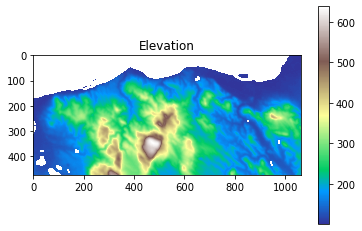

Name: elevation Limits: (100.67122, 638.9841)
Mean: 219.7329864501953 Standard deviation: 95.92752838134766


In [3]:
show_grid(elevation.grid, nodata=elevation.nodata, name='Elevation', cmap='terrain')
elevation.show_info()

### Importing the landslide sample areas  
**LandslideMask** objects store the data for the mask. The mask is used to separate the landslide and the non-landslide areas. The splits for the cross-validation are also computed here. *The cross-validation will be explained later in this notebook.*  
- **name** : The name of the LandslideMask. Eg. *'scarps'*
- **path** : Path to the raster grid of the layer. The same conditions apply as for the VRasters. Eg. *'./data/landslide_layer.sdat'*
- **ls_marker** : The value marking the landslide pixels in the mask layer. Eg. *1*  
- **nls_marker** : The value marking the landslide pixels in the mask layer. Eg. *0*    
- **fold_count** : The number of folds for the cross-validation. Eg. *5*  

In [4]:
scarps = LandslideMask(name='scarps',
                       path='./data/scarps.sdat',
                       ls_marker=1,
                       fold_count=5)

Let's plot the mask. Non-landslide areas are blue and landslide areas are red.

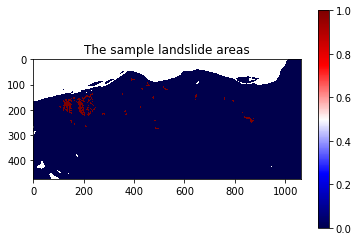

In [5]:
show_grid(scarps.grid, nodata=scarps.nodata, name='The sample landslide areas', cmap='seismic', interpolation='none')

## Running the analysis
The **frequency ratio analysis** is performed on a list of **VRasters** and on a **LandslideMask**. These hold the grids of the analyzed data and the landslide mask.  

You have to create an **FRAnalysis** object from the rasters and the mask to perform the analysis. This object will store all the data produced during the analysis.  

- **ls_mask** : The LandslideMask for the analysis
- **var_list** : The list of the VRasters to analyze

In [6]:
fra = FRAnalysis(ls_mask=scarps,
                 var_list=[slope,
                           geology,
                           elevation]
                 )

The **frequency ratios** and the **reclassified frequency ratio grids** are computed on the creation of the **FRAnalysis** object. The statistics are stored in the **fr_stats_full** property of the object. The reclassified grids are stored in the **rc_folds** property.  
Let's check the statistics for the slope layer.

In [7]:
fra.fr_stats_full['slope'][0]

,min,max,LS_density,NLS_density,frequency_ratio
0,0.000957,1.633130,0.002002,0.208784,0.009586
1,1.633130,3.265303,0.022267,0.161319,0.138029
2,3.265303,4.897476,0.094821,0.154318,0.614455
3,4.897476,6.529649,0.211909,0.146147,1.449973
4,6.529649,8.161822,0.249187,0.114662,2.173228
5,8.161822,9.793995,0.169127,0.078661,2.150064
6,9.793995,11.426168,0.109082,0.050567,2.157191
7,11.426168,13.058341,0.068051,0.030248,2.249766
8,13.058341,14.690514,0.039029,0.019335,2.018633
9,14.690514,16.322687,0.009507,0.012908,0.736524


You can also plot the statistics. Change 'slope' to 'elevation' or 'geology_14' to check the other layers.

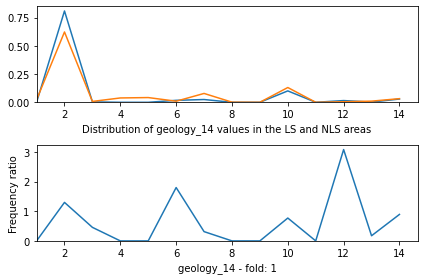

In [8]:
slope_plot = fra.plot_var_fold_fr('geology_14', 0)

### Susceptibility grid
The susceptibility grid is computed by averaging the reclassified grids. You have to call the get_result function of the FRAnalysis to compute the susceptibility grid and some other related data.  
Let's compute and plot the susceptibility estimates.

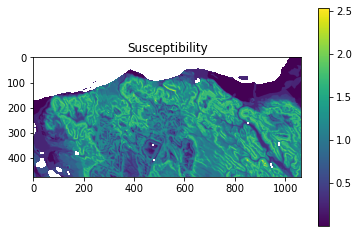

In [9]:
result_percentile_bins = fra.get_result()
show_grid(fra.fold_susceptibility[0], nodata=-99999, name="Susceptibility")

The results are also available in a percentile form. In the percentile form, X means that X% of the pixels in the study area have lower susceptibility than pixels with X susceptibility. Eg. 90% of the pixels have lower susceptibility than pixels in the 90th percentile.  
Plot the percentile grid.

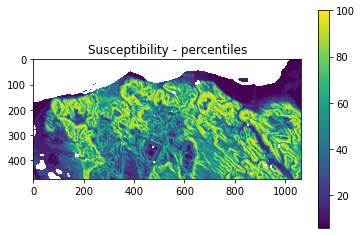

In [10]:
show_grid(fra.fold_percentiles[0], nodata=-99999, name="Susceptibility - percentiles")

## Cross-validation
*Scientists need a way (or more) to test the correctness of their findings. In our case,  we'd like to see if the areas with high landslide susceptibility scores are actually prone to landslides or not. To get the most accurate measurement, we'd have to wait several years and evaluate the results with exhaustive ground checks on the field. In the meantime, we have to work with the already available data to get information about the accuracy of the results.*  

The **frmod** script uses k-fold cross validation with random splits to evaluate the results.
1. The landslide area is split into equal sized parts, called splits.
2. One part is attached to the non-landslide area, these are the validation pixels
3. The result of the analysis is evaluated by checking the number of validation pixels in the different susceptibility categories
4. This process is then repeated with each split
5. The final susceptibility estimates are the average of the results of the runs with the different splits

The cross-validation is always used during the analysis. The splits are created with the LandslideMask.  
The results you have just computed were the results with the first split. You can plot the distribution of the validation pixels in the susceptibility categories for the first split.  
To check the results, just run the code below.

(0.0, 6.51)

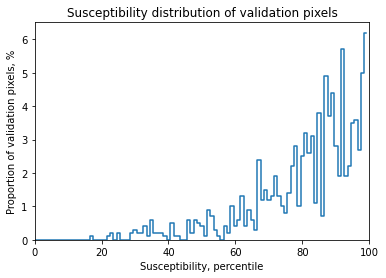

In [11]:
fig, ax = plt.subplots()
plt.title("Susceptibility distribution of validation pixels")
ax.set_xlabel("Susceptibility, percentile")
ax.set_ylabel("Proportion of validation pixels, %")
d = ax.plot(fra.v_dist[0] * 100, drawstyle="steps-mid")
ax.set_xlim(left=0, right=100)
ax.set_ylim(bottom=0)

The results are considered more accurate when a higher number of validation pixels fall into the higher susceptibility categories. It would be the best if only validation pixels would be in the highest susceptibility categories.
#### Metrics - Success rate curve
The cumulative sum of the distribution above is called the success rate curve. It shows the proportion of validation pixels that fall into or below a certain susceptibility category.  
Let's compute and plot this curve for all splits by calling the get_src() and plot_success_rates() function of our FRAnalysis.

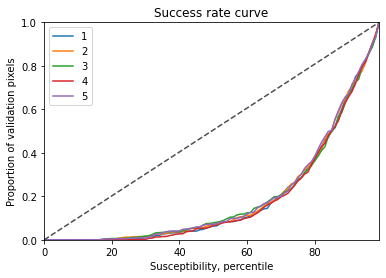

In [12]:
success_rates = fra.get_src()
fig_sr, ax_sr = fra.plot_success_rates()

#### Metrics - Area under the success rate curve
The accuracy of the model can be measured by the area under the cumulative distribution curve. Our aim is to have most of the validation landslide pixels in the high susceptibility categories, ie. to get the area under the cumulative distribution curve as small as possible.  
The area under the curve (AUC) is computed by the get_auc() function of our FRAnalysis class object. The function prints the **AUC** values for all splits along with the mean and the standard deviation of the scores.

In [13]:
auc_folds = fra.get_auc()

Auc: 18.827000000000005
Auc: 19.23400000000001
Auc: 19.223223223223222
Auc: 18.49149149149149
Auc: 19.563563563563562
Mean score: 19.067855655655656; Std: 0.3708575065347553


If you would like to experiment with the analysis, you can change some parameters and run it again. Try to get a better score than the current one.

## The final result
The analysis is performed with cross-validation that produces one susceptibility grid for each split. The final result of the analysis is the average of the susceptibility grids, converted into the percentile form. Compute and plot it with the get_percentile_grid(show=True) function.

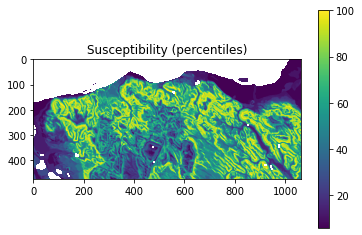

In [14]:
fra.get_percentile_grid(show=True)

## Output
The frmod package stores the results and the related statistics in the corresponding FRAnalysis object. It is possible to plot or export the created data with a set of functions. This way you can analyze or view the results elsewhere.  

frmod's utils module has a set of function for reading and writing raster grids.  
The **array2raster()** is used to save the 2D arrays (grids) that we produced during the analysis. The function needs 3 parameters + 1 optional parameter:
- **rasterfn** : Path to the raster used as a sample. The function copies the characterictics (shape, resolution, projection, nodata) of this raster to the new raster
- **new_raster_fn** : Path and name of the new raster
- **array** : The array to save
- **driver** : A GDAL raster driver, eg. *'GTiff'*

Save the final percentile susceptibility grid with it.

In [20]:
import os
from frmod.utils import array2raster
# Create the output folder if it does not exist
if os.path.isdir('output') is False:
    os.makedirs('output')

# Save the percentile susceptibility grid (array) to a georeferenced raster
array2raster(rasterfn=slope.path,
             new_raster_fn='./output/percentile_susceptibility.tif',
             array=fra.percentile_grid,
             driver='GTiff'
            )

The success rate curves can also be saved to a csv file:
- **folder** : Path to the output folder. The default is "./output/".
- **fname** : Output filename with extension. The default is "src.csv".

In [21]:
fra.save_src(folder='./output/', fname='success_rates.csv')

The save_stats function of the FRAnalysis object saves the frequency ratios for each analyzed layer and split to csv files.
- **folder** : Path to the output folder. The default is "./output/".
- **tag** : Tag inserted to the beginning of the file name. The default is "".


In [22]:
fra.save_stats(tag="notebook_output")

The statistics with the landslide and non-landslide distributions and the frequency ratios are stored in the fr_stats_full dictionary of the FRanalysis. The keys are the name properties of the VRasters. The items are lists with one pandas.DataFrame for each fold's statistics. You can use the built-in methods of pandas for saving these statistics.

In [26]:
import pandas as pd
fra.fr_stats_full['slope'][0].to_csv('./output/fr_stats_slope_1.csv')

Check if the files have been saved to the output folder by listing the files in the folder.

In [25]:
os.listdir('./output')

['fr_stats_slope_1.csv',
 'notebook_output_elevation.csv',
 'notebook_output_geology_14.csv',
 'notebook_output_slope.csv',
 'percentile_susceptibility.tif',
 'src.csv',
 'success_rates.csv']